# Import des librairies 

In [1]:
from pymongo import MongoClient
from ssh_pymongo import MongoSession
import pandas as pd
import time

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 

# Connexion 

In [2]:
session = MongoSession(
    "MESIIN592022-0055.westeurope.cloudapp.azure.com",
    port=22,
    user='administrateur',
    password='SuperPassword!1',
    uri="mongodb://MESIIN592022-0055:30000/")

movies = session.connection['movies']
#Un warning apparaît mais il n'impacte pas l'exécution des requêtes.

2022-12-10 15:36:09,865| ERROR   | Password is required for key C:\Users\qnava/.ssh\id_rsa


In [3]:
def run_query_names(movies, pipeline):
    return movies.Movies_sharding_name.aggregate(pipeline,allowDiskUse=True)

def run_query_year(movies, pipeline):
    return movies.Movies_sharding_year.aggregate(pipeline,allowDiskUse=True)

## Initialisation des pipelines des  requêtes

In [5]:
dict_queries ={}
dict_queries["requête_1"]= [{
                        "$match": {
                            "name": 'Modern Times'
                        }
                    }, {
                        "$project": {
                            "name": 1,
                            "year": 1,
                            "rank": 1,
                            "genre": 1,
                            'directors.first_name': 1,
                            'directors.last_name': 1,
                            "roles": 1
                        }
                    }]

dict_queries["requête_2"]= [{
                         "$match": {
                          'roles.first_name': 'Norman',
                          'roles.last_name': 'Ainsley'
                         }
                        }, {
                         "$project": {
                          "name": 1}}]

dict_queries["requête_3"]= [{
                         "$match": {
                          'roles.first_name': 'Norman',
                          'roles.last_name': 'Ainsley'
                         }
                        }, {
                         "$unwind": {
                          "path": '$roles',
                          "includeArrayIndex": 'string',
                          "preserveNullAndEmptyArrays": False
                         }
                        }, {
                         "$group": {
                          "_id": {
                           "_id": '$roles.actor_id',
                           "first_name": '$roles.first_name',
                           "last_name": '$roles.last_name'
                          },
                          "fieldN": {
                           "$sum": 1
                          }
                         }
                        }, {
                         "$sort": {
                          "fieldN": -1}}]

dict_queries["requête_4"]= [{
                             "$match": {
                              'directors.first_name': 'Charles',
                              'directors.last_name': 'Chaplin'
                             }
                            }, {
                             "$project": {
                              "path": '$directors.genres'
                             }
                            }, {
                             "$limit": 1}]

dict_queries["requête_5"]= [{
                         "$match": {
                          "genre": 'Comedy'
                         }
                        }, {
                         "$unwind": {
                          "path": '$directors',
                          "includeArrayIndex": 'string',
                          "preserveNullAndEmptyArrays": False
                         }
                        }, {
                         "$group": {
                          "_id": '$directors',
                          "fieldN": {
                           "$sum": 1
                          }
                         }
                        }, {
                         "$sort": {
                          "fieldN": -1
                         }
                        }, {
                         "$limit": 3
                        }]

dict_queries["requête_7"]= [{
                         "$match": {
                          "year": {
                           "$gt": 2002
                          },
                          "genre": {
                           "$ne": "null"
                          },
                          "rank": {
                           "$ne": "null"
                          }
                         }
                        }, {
                         "$unwind": {
                          "path": '$genre',
                          "includeArrayIndex": 'string',
                          "preserveNullAndEmptyArrays": False
                         }
                        }, {
                         "$group": {
                          "_id": {
                           "genre": '$genre',
                           "year": '$year'
                          },
                          "fieldN": {
                           "$avg": '$rank'
                          }
                         }
                        }, {
                         "$sort": {
                          "fieldN": -1
                         }
                        }, {
                         "$group": {
                          "_id": '$_id.year',
                          "note_moyenne": {
                           "$first": '$fieldN'
                          },
                          "top": {
                           "$first": '$_id'
                          }
                         }
                        }]


dict_queries["requête_8"]= [{"$unwind": {"path": '$roles',"includeArrayIndex": 'string',"preserveNullAndEmptyArrays": False}}, 
                            {"$group": {"_id": '$roles.actor_id',"last_name": {"$first": '$roles.last_name'},
                          "first": {"$first": '$roles.first_name'},
                          "max": {"$max": '$year'},"min": {"$min": '$year'}}}, 
                            {"$addFields": {"dif": {"$subtract": ['$max','$min']}}}, 
                            {"$sort": {"dif": -1}}]



# Exécution du code 

## Pour chaque configuration on réexécute le code à partir d'ici 

### Paramères de la configuration

In [19]:
#Nombre de shards de la configuration 
num_shards=1

#Nombre de fois que l'on exécute chaque requête 
num_run = 10

### Lecture du dataframe 

In [7]:
df_results= pd.read_csv("enregistrements.csv",sep="\t")
df_results.head()

,Sharding,Nb_shards,Requete,Temp_exec,Num_run,Mean_ref_time,Std_ref_time
0,Names,3,requête_1,0.040992,0,0.231475,0.00703
1,Names,3,requête_1,0.046078,1,0.231475,0.00703
2,Names,3,requête_1,0.041978,2,0.231475,0.00703
3,Names,3,requête_1,0.041296,3,0.231475,0.00703
4,Names,3,requête_1,0.042637,4,0.231475,0.00703


 ## Sharding sur Movie_names 

### Exécution des requêtes pour la collection shardée sur Movie_names

In [21]:
sharding="Names"
ref= []
# On exécute 100 fois une requête simple pour avoir une référence de comparaison entre les configurations
for i in tqdm(range(100)): 
    start = time.time()
    results=  run_query_names(movies,[{"$count":"id"}])
    end=time.time()
    ref.append(end-start)
ref_mean=np.mean(ref)
ref_std = np.std(ref)
print("Mean temps ref : ",ref_mean)
print("Std temps ref : ",ref_std)

#On execute num_run fois chacune des autres requêtes
for query in list(dict_queries.keys()) : 
    print("Requête : ",query)
    for i in range(num_run) : 
        start = time.time()
        results=  run_query_names(movies,dict_queries[query])
        end=time.time()
        df_results= df_results.append({"Sharding":sharding,"Nb_shards":num_shards,"Requete":query, "Temp_exec":end-start,"Num_run":i,"Mean_ref_time":ref_mean,"Std_ref_time":ref_std}, ignore_index=True)

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Mean temps ref :  0.47439605951309205
Std temps ref :  0.011072152698238287
Requête :  requête_1
Requête :  requête_2
Requête :  requête_3
Requête :  requête_4
Requête :  requête_5
Requête :  requête_7
Requête :  requête_8


### On enregistre les résultats

In [22]:
df_results.to_csv("enregistrements.csv",sep="\t", index=False)
df_results.head()

,Sharding,Nb_shards,Requete,Temp_exec,Num_run,Mean_ref_time,Std_ref_time
0,Names,3,requête_1,0.040992,0,0.231475,0.00703
1,Names,3,requête_1,0.046078,1,0.231475,0.00703
2,Names,3,requête_1,0.041978,2,0.231475,0.00703
3,Names,3,requête_1,0.041296,3,0.231475,0.00703
4,Names,3,requête_1,0.042637,4,0.231475,0.00703


### Boxplots des temps d'exécution

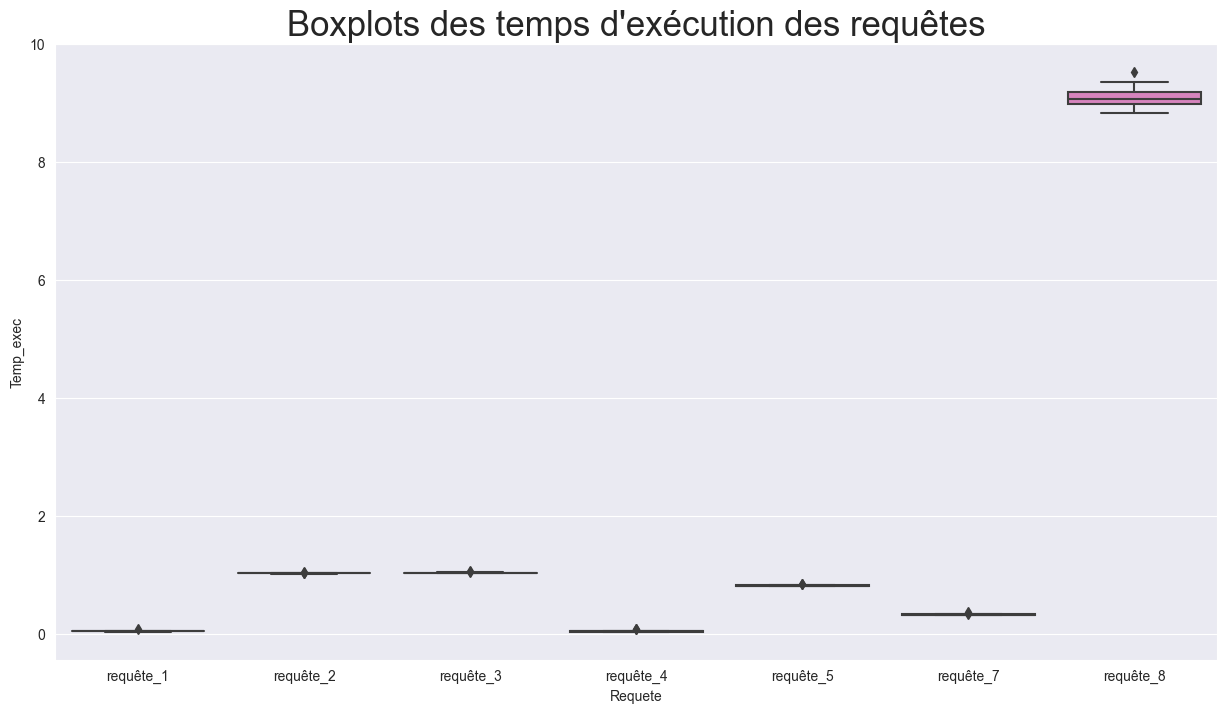

In [23]:
sns.boxplot(data=df_results[(df_results["Nb_shards"]==num_shards) & (df_results["Sharding"]==sharding)], x="Requete", y="Temp_exec")
plt.title("Boxplots des temps d'exécution des requêtes", fontsize=25)
plt.show()

## Sharding sur year : 

### On recharge les données 

In [24]:
df_results = pd.read_csv("enregistrements.csv", sep="\t")

### Exécution des requêtes pour la collection shardée sur Movie_year

In [25]:
sharding="year"
ref= []
for i in tqdm(range(100)): 
    start = time.time()
    results= run_query_year(movies,[{"$count":"id"}])
    end=time.time()
    ref.append(end-start)
ref_mean=np.mean(ref)
ref_std = np.std(ref)
print("Mean temps ref : ",ref_mean)
print("Std temps ref : ",ref_std)

for query in list(dict_queries.keys()) : 
    print("Requête : ",query)
    for i in range(num_run) : 
        start = time.time()
        results=  run_query_year(movies,dict_queries[query])
        end=time.time()
        df_results= df_results.append({"Sharding":sharding,"Nb_shards":num_shards,"Requete":query, "Temp_exec":end-start,"Num_run":i,"Mean_ref_time":ref_mean,"Std_ref_time":ref_std}, ignore_index=True)

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Mean temps ref :  0.46854127645492555
Std temps ref :  0.014411549212264873
Requête :  requête_1
Requête :  requête_2
Requête :  requête_3
Requête :  requête_4
Requête :  requête_5
Requête :  requête_7
Requête :  requête_8


### On enregistre les résultats

In [26]:
df_results.to_csv("enregistrements.csv",sep="\t", index=False)

### On affiche les boxplots des temps d'exécution par requête

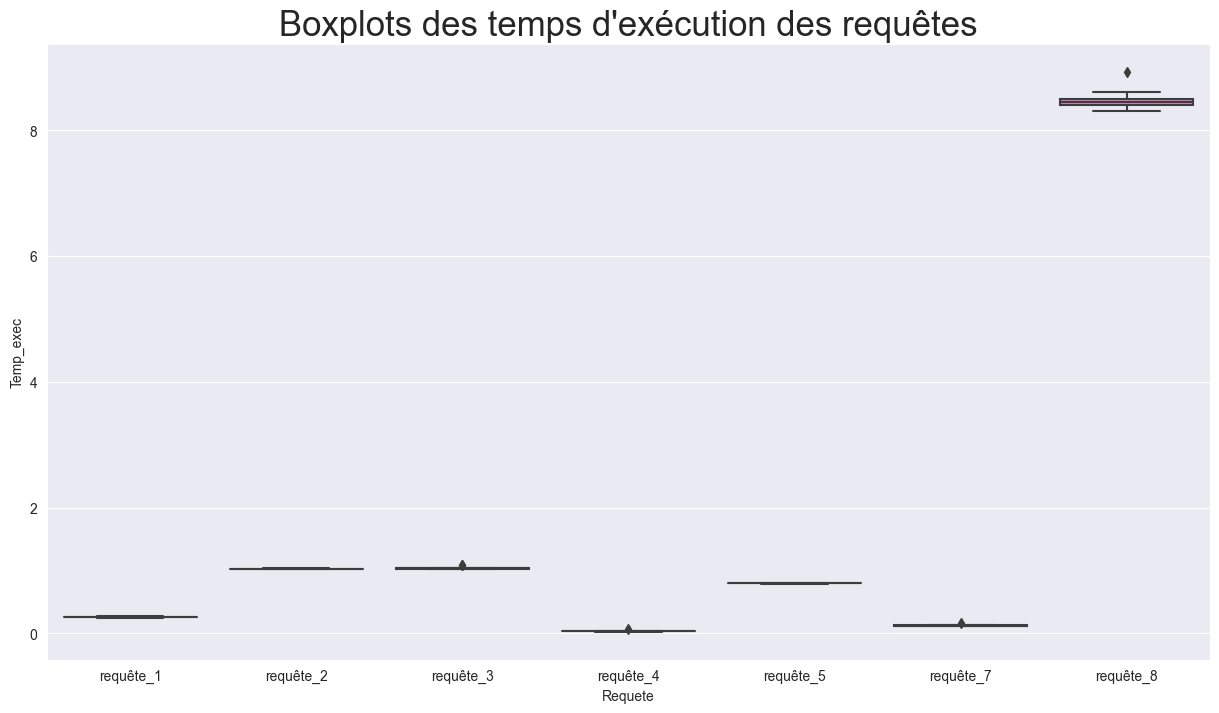

In [33]:
sns.boxplot(data=df_results[(df_results["Nb_shards"]==num_shards) & (df_results["Sharding"]==sharding)], x="Requete", y="Temp_exec")
plt.title("Boxplots des temps d'exécution des requêtes", fontsize=25)
plt.show()

### Autres requêtes pouvant être utiles

# Informations sur la structure de la base : 

## Clés de sharding : 

In [8]:
movies.Movies_sharding_name.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'name_1': {'v': 2, 'key': [('name', 1.0)]}}

In [9]:
movies.Movies_sharding_year.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'year_1': {'v': 2, 'key': [('year', 1.0)]}}